In [1]:
import gurobipy as gp
from   gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from   IPython.display import display
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
# Supply from cities
supply = {
    'NewYork'      : 300000,
    'NewJersey'    : 400000
}  
# Depot throughput limits
through = {
    'Bronx'        : 140000,
    'Brooklyn'     : 100000,
    'Queens'       : 200000,
    'StatenIsland' :  80000
}
# Landfill demands
demand = {
    'C1'           : 100000,
    'C2'           :  20000,
    'C3'           :  80000,
    'C4'           :  70000,
    'C5'           : 120000,
    'C6'           :  40000,
    'C7'           :  50000   # New landfill for Variation 1
}
# Transportation costs
arcs, cost = gp.multidict({
    ('NewYork'     , 'Bronx')        : 0.7,
    ('NewYork'     , 'Brooklyn')     : 0.7,
    ('NewYork'     , 'Queens')       : 1.2,
    ('NewYork'     , 'StatenIsland') : 0.4,
    ('NewYork'     , 'C1')           : 1.2,
    ('NewYork'     , 'C3')           : 1.7,
    ('NewYork'     , 'C4')           : 2.2,
    ('NewYork'     , 'C6')           : 1.2,
    ('NewYork'     , 'C7')           : 2.0,  # new cost
    ('NewJersey'   , 'Brooklyn')     : 0.5,
    ('NewJersey'   , 'Queens')       : 0.7,
    ('NewJersey'   , 'StatenIsland') : 0.4,
    ('NewJersey'   , 'C1')           : 2.2,
    ('NewJersey'   , 'C7')           : 1.8,  # new cost
    ('Bronx'       , 'C2')           : 1.7,
    ('Bronx'       , 'C3')           : 0.7,
    ('Bronx'       , 'C4')           : 1.7,
    ('Bronx'       , 'C6')           : 1.2,
    ('Bronx'       , 'C7')           : 1.9,  # new cost
    ('Brooklyn'    , 'C1')           : 1.2,
    ('Brooklyn'    , 'C2')           : 0.7,
    ('Brooklyn'    , 'C3')           : 0.7,
    ('Brooklyn'    , 'C4')           : 1.2,
    ('Brooklyn'    , 'C5')           : 0.7,
    ('Brooklyn'    , 'C7')           : 1.5,  # new cost
    ('Queens'      , 'C2')           : 1.7,
    ('Queens'      , 'C3')           : 2.2,
    ('Queens'      , 'C5')           : 0.7,
    ('Queens'      , 'C6')           : 1.7,
    ('Queens'      , 'C7')           : 1.6,  # new cost
    ('StatenIsland', 'C3')           : 0.4,
    ('StatenIsland', 'C4')           : 1.7,
    ('StatenIsland', 'C5')           : 0.7,
    ('StatenIsland', 'C6')           : 1.7,
    ('StatenIsland', 'C7')           : 2.1  # new cost
})
# Create optimization model
# Create flow variables
# Supply limits
# Landfill demand
# Depot flow conservation
# Depot throughput limits
# Solve the model
model     = gp.Model('Landfill Transportation')
flow      = model.addVars(arcs, obj=cost, name="flow", vtype=GRB.CONTINUOUS)
centers   = supply.keys()  ; model.addConstrs((gp.quicksum(flow.select(center, '*'))      <= supply[center]                       for center   in centers)  , name="center")
landfills = demand.keys()  ; model.addConstrs((gp.quicksum(flow.select('*'   , landfill)) == demand[landfill]                     for landfill in landfills), name="landfill")
depots    = through.keys() ; model.addConstrs((gp.quicksum(flow.select(depot , '*'))      == gp.quicksum(flow.select('*', depot)) for depot    in depots)   , name="depot")
model.addConstrs((gp.quicksum(flow.select('*', depot)) <= through[depot] for depot in depots), name="depot_capacity")
model.optimize()

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F5053j)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17 rows, 35 columns and 77 nonzeros
Model fingerprint: 0xc9230d4f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+05]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 16 rows, 35 columns, 76 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5700000e+05   4.250000e+04   0.000000e+00      0s
      11    6.3100000e+05   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.310000000e+05


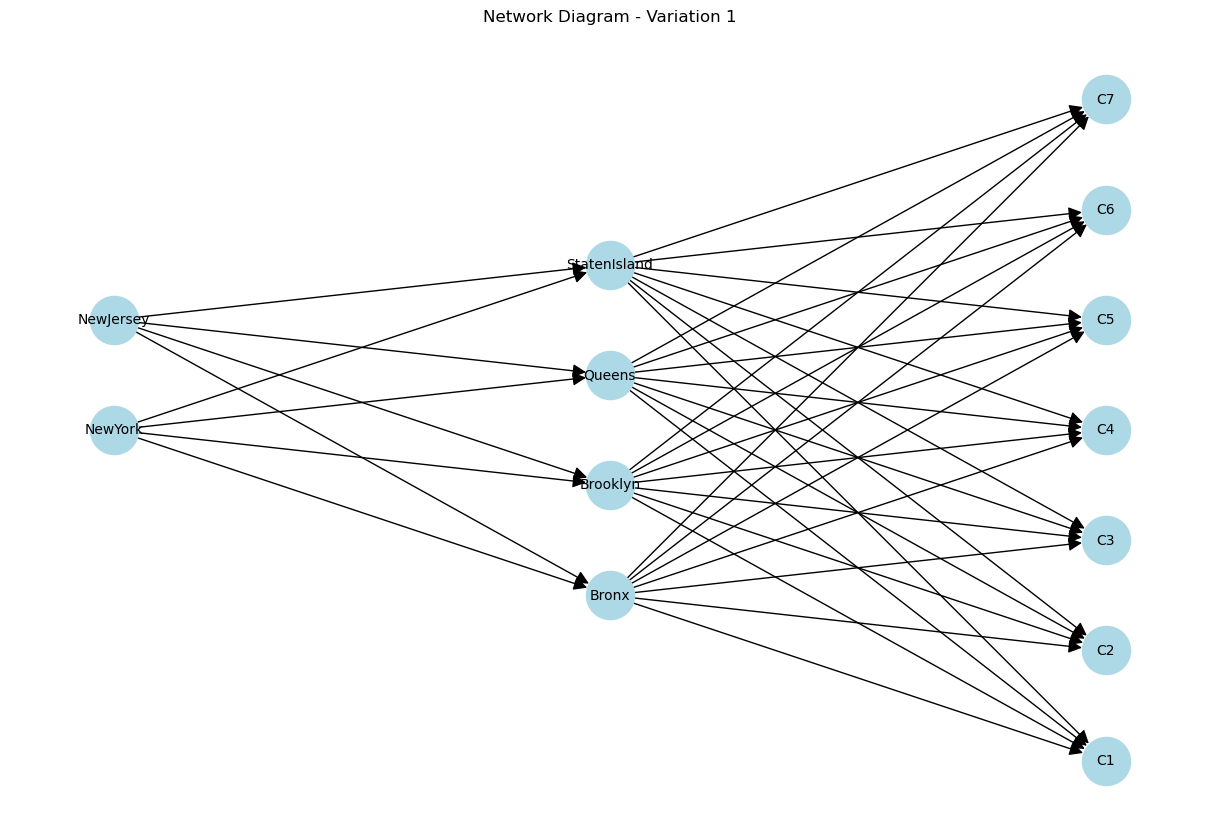

In [2]:
# Create directed graph
G = nx.DiGraph()
# Nodes
cities    = ['NewYork', 'NewJersey']
depots    = ['Bronx', 'Brooklyn', 'Queens', 'StatenIsland']
landfills = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
# Add nodes
G.add_nodes_from(cities)
G.add_nodes_from(depots)
G.add_nodes_from(landfills)
# Add edges
for city in cities:
    for depot in depots:
        G.add_edge(city, depot)
for depot in depots:
    for landfill in landfills:
        G.add_edge(depot, landfill)
# Define layout
pos = {}
# Cities on the left
for i, city in enumerate(cities):
    pos[city] = (-2, i)
# Depots in the center
for i, depot in enumerate(depots):
    pos[depot] = (0, i-1.5)
# Landfills on the right
for i, landfill in enumerate(landfills):
    pos[landfill] = (2, i-3)
# Draw
plt.figure(figsize=(12,8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1200, arrowsize=20, font_size=10)
plt.title('Network Diagram - Variation 1')
plt.axis('off')
plt.show()

Flow
------------------------------------


,From,To,Flow
,NewYork,C1,100000.0
,NewYork,C6,40000.0
,NewJersey,Brooklyn,100000.0
,NewJersey,Queens,110000.0
,NewJersey,StatenIsland,80000.0
,NewJersey,C7,50000.0
,Brooklyn,C2,20000.0
,Brooklyn,C4,70000.0
,Brooklyn,C5,10000.0
,Queens,C5,110000.0


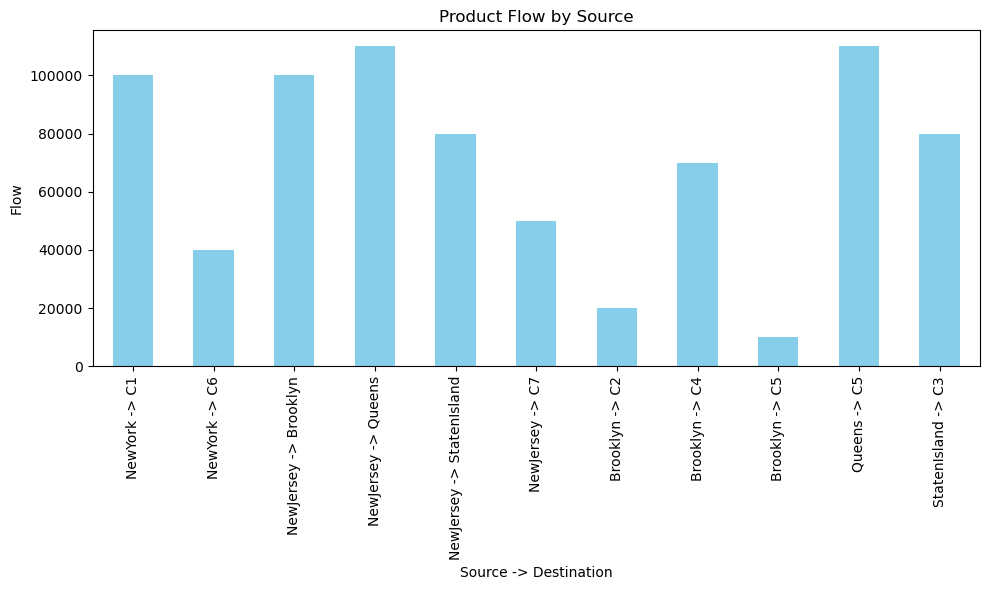

Cost
---------------------------------------------------


,From,To,cost,Flow,total
,NewYork,C1,1.2,100000.0,120000.0
,NewYork,C6,1.2,40000.0,48000.0
,NewJersey,Brooklyn,0.5,100000.0,50000.0
,NewJersey,Queens,0.7,110000.0,77000.0
,NewJersey,StatenIsland,0.4,80000.0,32000.0
,NewJersey,C7,1.8,50000.0,90000.0
,Brooklyn,C2,0.7,20000.0,14000.0
,Brooklyn,C4,1.2,70000.0,84000.0
,Brooklyn,C5,0.7,10000.0,7000.0
,Queens,C5,0.7,110000.0,77000.0


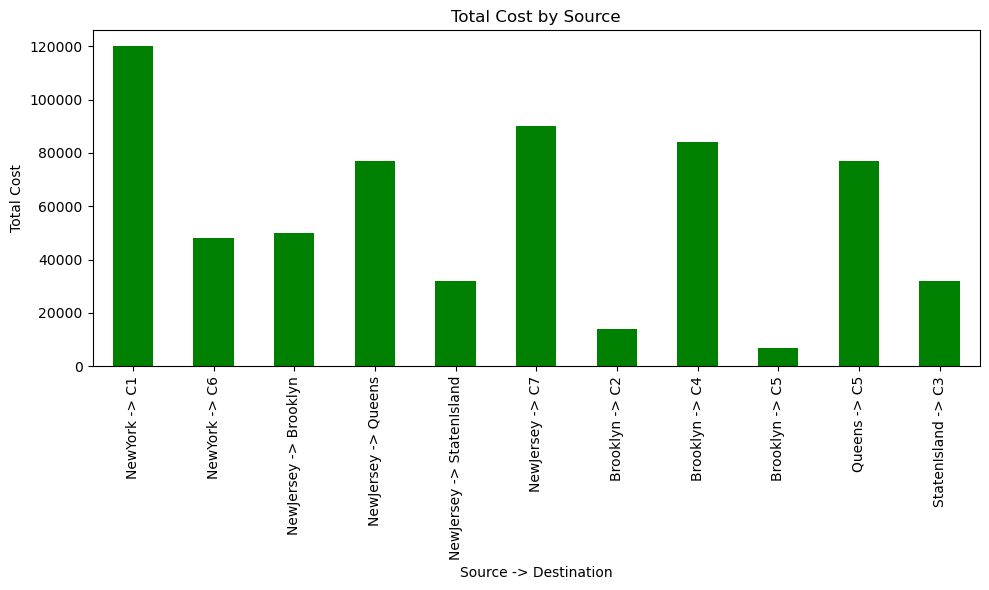

Total Cost:  631000.0


In [3]:
product_flow = pd.DataFrame(columns=["From", "To", "Flow"])
for arc in arcs:
    if flow[arc].x > 1e-6:
        # Create a new DataFrame for the current row
        new_row = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [flow[arc].x]})
        # Concatenate the new row with the existing DataFrame
        product_flow = pd.concat([product_flow, new_row], ignore_index=True)  
product_flow.index=[''] * len(product_flow)

k = 0 
product_cost = pd.DataFrame(columns=["From", "To", "cost", "Flow", "total"])
for arc in arcs:
    if flow[arc].x > 1e-6:
        k = k + cost[arc] * flow[arc].X
        # Create a new DataFrame for the current row
        new_row = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "cost": [cost[arc]], "Flow": [flow[arc].x], "total": [cost[arc] * flow[arc].x]})
        # Concatenate the new row with the existing DataFrame
        product_cost = pd.concat([product_cost, new_row], ignore_index=True)  
product_cost.index = [''] * len(product_cost)

print("Flow")
print("------------------------------------")
display(product_flow)
# Create a new column combining 'From' and 'To'
product_flow['From+To'] = product_flow['From'] + ' -> ' + product_flow['To']

# Plot using the new column
product_flow.plot(kind='bar', x='From+To', y='Flow', figsize=(10, 6), legend=False, color='skyblue')
plt.title('Product Flow by Source')
plt.xlabel('Source -> Destination')
plt.ylabel('Flow')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Cost")
print("---------------------------------------------------")
display(product_cost)
# Create a new column combining 'From' and 'To' for product_cost
product_cost['From+To'] = product_cost['From'] + ' -> ' + product_cost['To']

# Plot using the new column
product_cost.plot(kind='bar', x='From+To', y='total', figsize=(10, 6), legend=False, color='green')
plt.title('Total Cost by Source')
plt.xlabel('Source -> Destination')
plt.ylabel('Total Cost')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Total Cost: ", k)